Install Dependencies

In [1]:
!apt-get install ghostscript
!pip install camelot-py[cv]
!pip install google-colab python-docx pdf2image paddlepaddle paddleocr psycopg2-binary faiss-cpu numpy PyPDF2 tk
!apt-get install poppler-utils -y
!pip install psutil
!apt-get install -y libreoffice
!pip install pyuno



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 poppler-data
0 upgraded, 10 newly installed, 0 to remove and 29 not upgraded.
Need to get 16.7 MB of archives.
After this operation, 63.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-droid-fallback all 1:6.0.1r16-1.1build1 [1,805 kB]
Ge

Setup and Initialization

In [2]:
import os
from google.colab import drive
import psutil
import logging
import subprocess
import time
import shutil

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
base_path = '/content/drive/My Drive/lifesciences'
training_docs_path = os.path.join(base_path, 'training_documents')
staging_images_path = os.path.join(base_path, 'staging/images')
staging_pdfs_path = os.path.join(base_path, 'staging/pdfs')
processed_faiss_path = os.path.join(base_path, 'processed/content_faiss.index')

# Ensure directories exist
os.makedirs(staging_images_path, exist_ok=True)
os.makedirs(staging_pdfs_path, exist_ok=True)
os.makedirs(os.path.dirname(processed_faiss_path), exist_ok=True)

# Function to log memory usage
def log_memory(step=""):
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    mem_usage = mem_info.rss / 1024**2
    print(f"{step} - Memory usage: RSS (Resident Set Size= curreny RAM usage)={mem_usage:.2f} MB, VMS(Virtual Memory Size = RAM+Disk)={mem_info.vms / 1024**2:.2f} MB")
    if mem_usage > 10000:
        logger.warning("Memory usage exceeds 10 GB, potential crash risk")

log_memory("After setup")

Mounted at /content/drive
After setup - Memory usage: RSS (Resident Set Size= curreny RAM usage)=103.68 MB, VMS(Virtual Memory Size = RAM+Disk)=1159.29 MB


Convert DOCX to PDF

In [3]:
def docx_to_pdf(docx_path, staging_pdfs_path):
    pdf_filename = os.path.basename(docx_path).replace('.docx', '.pdf')
    pdf_path = os.path.join(staging_pdfs_path, pdf_filename)
    print(f"Attempting to convert {docx_path} to {pdf_path}")

    local_docx = f"/tmp/{os.path.basename(docx_path)}"
    shutil.copy(docx_path, local_docx)

    cmd = f"libreoffice --headless --convert-to pdf \"{local_docx}\" --outdir \"{staging_pdfs_path}\""
    print(f"Running command: {cmd}")
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    print(f"LibreOffice conversion stdout: {result.stdout}")
    print(f"LibreOffice conversion stderr: {result.stderr}")

    time.sleep(5)

    if not os.path.exists(pdf_path):
        logger.error(f"Conversion failed: {pdf_path} not found")
        raise FileNotFoundError(f"PDF not found after conversion: {pdf_path}")

    print(f"Conversion successful: {pdf_path} created")
    os.remove(local_docx)
    log_memory("After conversion")
    return pdf_path

# Process one file
filename = "Text_Only_URS_Analytical_Instrument_Data_Management_System.docx"
file_path = os.path.join(training_docs_path, filename)
urs_name = input(f"Enter URS name for {filename} (converted to PDF): ")
staged_pdf_path = docx_to_pdf(file_path, staging_pdfs_path)

Enter URS name for Text_Only_URS_Analytical_Instrument_Data_Management_System.docx (converted to PDF): Analytical_Instrument_Data_Management_System
Attempting to convert /content/drive/My Drive/lifesciences/training_documents/Text_Only_URS_Analytical_Instrument_Data_Management_System.docx to /content/drive/My Drive/lifesciences/staging/pdfs/Text_Only_URS_Analytical_Instrument_Data_Management_System.pdf
Running command: libreoffice --headless --convert-to pdf "/tmp/Text_Only_URS_Analytical_Instrument_Data_Management_System.docx" --outdir "/content/drive/My Drive/lifesciences/staging/pdfs"
LibreOffice conversion stdout: convert /tmp/Text_Only_URS_Analytical_Instrument_Data_Management_System.docx -> /content/drive/My Drive/lifesciences/staging/pdfs/Text_Only_URS_Analytical_Instrument_Data_Management_System.pdf using filter : writer_pdf_Export
Overwriting: /content/drive/My Drive/lifesciences/staging/pdfs/Text_Only_URS_Analytical_Instrument_Data_Management_System.pdf

LibreOffice conversio

Initialize OCR and Process PDF

Configuration:
- PDF path: /content/drive/My Drive/lifesciences/staging/pdfs
- URS name: Analytical_Instrument_Data_Management_System
- Images path: /content/drive/My Drive/lifesciences/staging/images
- FAISS index path: /content/drive/My Drive/lifesciences/processed/faiss_index.bin
Starting to process PDF: /content/drive/My Drive/lifesciences/staging/pdfs/Text_Only_URS_Analytical_Instrument_Data_Management_System.pdf
Initializing PP-Structure...
download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:16<00:00, 231.57it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:17<00:00, 557.81it/s]


download https://paddleocr.bj.bcebos.com/ppstructure/models/slanet/en_ppstructure_mobile_v2.0_SLANet_infer.tar to /root/.paddleocr/whl/table/en_ppstructure_mobile_v2.0_SLANet_infer/en_ppstructure_mobile_v2.0_SLANet_infer.tar


100%|██████████| 9955/9955 [00:17<00:00, 553.67it/s] 


download https://paddleocr.bj.bcebos.com/ppstructure/models/layout/picodet_lcnet_x1_0_fgd_layout_infer.tar to /root/.paddleocr/whl/layout/picodet_lcnet_x1_0_fgd_layout_infer/picodet_lcnet_x1_0_fgd_layout_infer.tar


100%|██████████| 9860/9860 [00:19<00:00, 497.47it/s] 


download https://paddleocr.bj.bcebos.com/contribution/rec_latex_ocr_infer.tar to /root/.paddleocr/whl/formula/rec_latex_ocr_infer/rec_latex_ocr_infer.tar


100%|██████████| 104000/104000 [00:27<00:00, 3736.80it/s] 


[2025/03/05 09:23:32] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

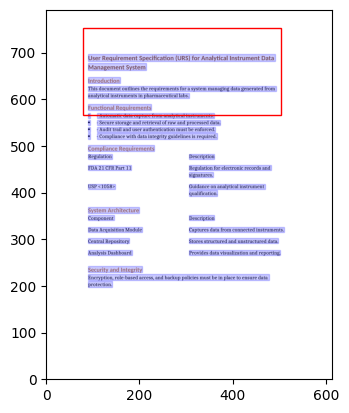

In [5]:
import os
import gc
import numpy as np
import psutil
import psycopg2
import faiss
import pdf2image
from pdf2image import convert_from_path
from paddleocr import PPStructure
import camelot
from google.colab import userdata

def log_memory(step=""):
    """Track and print memory usage at different steps."""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    mem_usage = mem_info.rss / 1024**2
    print(f"{step} - Memory usage: RSS={mem_usage:.2f} MB, VMS={mem_info.vms / 1024**2:.2f} MB")
    if mem_usage > 10000:
        print("WARNING: Memory usage exceeds 10 GB, potential crash risk")

def setup_database(db_params):
    """Setup database connection and tables."""
    print("Connecting to database...")
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()

    print("Creating metadata table if needed...")
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS metadata (
            id SERIAL PRIMARY KEY,
            urs VARCHAR(255) NOT NULL,
            section VARCHAR(255),
            type VARCHAR(50) NOT NULL,
            content TEXT NOT NULL,
            coordinates VARCHAR(100),
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            CONSTRAINT valid_type CHECK (type IN ('title', 'text', 'list', 'table', 'figure'))
        );
    """)
    conn.commit()
    print("Database setup complete")

    # Get current max ID
    cursor.execute("SELECT COALESCE(MAX(id), 0) FROM metadata")
    id_seq = cursor.fetchone()[0]
    print(f"Starting with database ID: {id_seq}")

    return conn, cursor, id_seq

def extract_text_content(item):
    """Extract content from text items."""
    print("Extracting text content...")
    content = ""

    if isinstance(item['res'], list):
        content_list = []
        for sub_item in item['res']:
            try:
                if isinstance(sub_item, dict) and 'text' in sub_item:
                    content_list.append(sub_item['text'])
                elif isinstance(sub_item, str):
                    content_list.append(sub_item)
            except Exception as e:
                print(f"Error with text item: {e}")
        content = '\n'.join(content_list)
    elif isinstance(item['res'], dict) and 'text' in item['res']:
        content = item['res']['text']
    elif isinstance(item['res'], str):
        content = item['res']
    else:
        content = item.get('res', {}).get('text', '')

    return content

def extract_list_content(item):
    """Extract content from list items."""
    print("Extracting list content...")
    content = ""

    if 'res' in item:
        if isinstance(item['res'], list):
            content_list = []
            for sub_item in item['res']:
                try:
                    if isinstance(sub_item, dict) and 'text' in sub_item:
                        content_list.append(sub_item['text'])
                    elif isinstance(sub_item, str):
                        content_list.append(sub_item)
                except Exception as e:
                    print(f"Error with list item: {e}")
            content = '\n'.join(content_list)
        elif isinstance(item['res'], dict) and 'text' in item['res']:
            content = item['res']['text']
        elif isinstance(item['res'], str):
            content = item['res']
        else:
            content = "List content could not be extracted."
    else:
        content = "List content not found."

    return content

def extract_table_content(item):
    """Extract content from table items."""
    print("Extracting table content...")

    if 'res' in item:
        if 'html' in item['res']:
            return item['res']['html']
        elif 'cells' in item['res']:
            return '\n'.join([' | '.join(cell.get('text', '') for cell in row)
                             for row in item['res']['cells']])
        else:
            return item['res'].get('text', 'Table detected')
    return "Table content not found"

def save_to_database(cursor, conn, id_seq, urs_name, section, item_type, content, coordinates):
    """Save content to database."""
    cursor.execute("""
        INSERT INTO metadata (id, urs, section, type, content, coordinates)
        VALUES (%s, %s, %s, %s, %s, %s)
    """, (id_seq, urs_name, section, item_type, content, str(coordinates)))
    conn.commit()
    print(f"Saved {item_type} to database, ID: {id_seq}")
    return id_seq + 1

def process_page(page_num, pdf_path, structure, staging_path, current_section,
                cursor, conn, id_seq, urs_name, faiss_index):
    """Process a single PDF page."""
    print(f"Processing page {page_num+1}")
    try:
        # Convert PDF to image
        images = convert_from_path(pdf_path, dpi=100, first_page=page_num+1, last_page=page_num+1)
        image = images[0]
        image_path = os.path.join(staging_path, f"page_{page_num}.png")
        print(f"Saving image to: {image_path}")
        image.save(image_path, 'PNG')

        if not os.path.exists(image_path):
            print(f"ERROR: Image save failed for page {page_num+1}")
            return current_section, id_seq

        # Run layout analysis
        print(f"Analyzing page {page_num+1} layout...")
        layout_result = structure(image_path)
        print(f"Found {len(layout_result)} elements on page {page_num+1}")
        layout_result = sorted(layout_result, key=lambda x: x['bbox'][1])
        # Process each element
        for item in layout_result:
            item_type = item['type'].lower()
            print(f"Processing {item_type} element")

            coordinates = item.get('bbox', [0, 0, 0, 0])
            content = ""

            # Extract content based on type
            if item_type == 'title':
                content = item['res'][0].get('text', 'Unknown Title')
                current_section = content
                print(f"New section: {current_section}")

            elif item_type == 'text':
                content = extract_text_content(item)

            elif item_type == 'list':
                content = extract_list_content(item)

            elif item_type == 'table':
                content = extract_table_content(item)

            elif item_type == 'figure':
                content = item.get('res', {}).get('text', 'Figure detected')

            # Skip empty content
            if not content.strip():
                print("Skipping empty content")
                continue

            # Save to database
            id_seq = save_to_database(cursor, conn, id_seq, urs_name,
                                      current_section, item_type, content, coordinates)

            # Add to FAISS index
            embedding = np.random.rand(64).astype('float32')
            faiss_index.add(np.array([embedding]))

        # Clean up
        del images, image, layout_result
        gc.collect()
        log_memory(f"Completed page {page_num+1}")

        return current_section, id_seq

    except Exception as e:
        print(f"ERROR processing page {page_num+1}: {e}")
        return current_section, id_seq

def process_pdf(pdf_path, urs_name, staging_images_path, processed_faiss_path, db_params, max_pages=10):
    """Main PDF processing function."""
    print(f"Starting to process PDF: {pdf_path}")

    # Initialize components
    print("Initializing PP-Structure...")
    structure = PPStructure(table=True, ocr=True, use_gpu=True, layout=True,
                           layout_score_threshold=0.1, layout_nms_threshold=0.3, lang='en')
    log_memory("PP-Structure initialized")

    # Setup database
    conn, cursor, id_seq = setup_database(db_params)

    # Initialize FAISS
    print("Initializing FAISS index...")
    faiss_index = faiss.IndexFlatL2(64)

    # Create staging directory
    if not os.path.exists(staging_images_path):
        print(f"Creating directory: {staging_images_path}")
        os.makedirs(staging_images_path)


    print(f"Camelot attempting to detect tables at the path...{pdf_path}")

    # First, try extracting with the 'stream' flavor
    tables_stream = camelot.read_pdf(pdf_path, flavor="stream", strip_text="\n", row_tol=10)
    valid_tables_stream = [table for table in tables_stream if table.df.shape[1] >= 2]

    # Then, try extracting with the 'lattice' flavor
    tables_lattice = camelot.read_pdf(pdf_path, flavor="lattice", line_scale=40)


    # Iterate over the combined tables and print the page number where a table is detected
    for idx, table in enumerate(valid_tables_stream):
        print(f"Camlot Table Stream detected on page {table.page}")
        print(table.df.to_string(index=False, header=True))
        camelot.plot(table, kind="contour").show()
        print("\n")

    for idx, table in enumerate(tables_lattice):
      print(f"Camlot Table Lattice detected on page {table.page}")
      camelot.plot(table, kind="contour").show()
      print("\n")


    # Get PDF info
    print("Getting PDF information...")
    pdf_info = pdf2image.pdfinfo_from_path(pdf_path)
    total_pages = pdf_info["Pages"]
    print(f"PDF has {total_pages} pages")

    pages_to_process = min(total_pages, max_pages) if max_pages else total_pages
    print(f"Will process {pages_to_process} pages")

    # Process pages
    current_section = ''
    for page in range(pages_to_process):
        current_section, id_seq = process_page(
            page, pdf_path, structure, staging_images_path,
            current_section, cursor, conn, id_seq, urs_name, faiss_index
        )

    # Save FAISS index
    faiss_dir = os.path.dirname(processed_faiss_path)
    if not os.path.exists(faiss_dir):
        print(f"Creating directory: {faiss_dir}")
        os.makedirs(faiss_dir)

    print(f"Saving FAISS index to: {processed_faiss_path}")
    faiss.write_index(faiss_index, processed_faiss_path)
    print("FAISS index saved successfully")

    # Close database
    cursor.close()
    conn.close()
    print("Database connection closed")

    print(f"PDF processing complete for {urs_name}")

# Main execution
if __name__ == "__main__":
    # Setup configuration
    db_params = {
        'dbname': os.environ.get('DB_NAME', userdata.get('DB_NAME')),
        'user': os.environ.get('DB_USER', userdata.get('DB_USER')),
        'password': os.environ.get('DB_PASSWORD',  userdata.get('DB_PASSWORD')),
        'host': os.environ.get('DB_HOST', userdata.get('DB_HOST')),
        'port': os.environ.get('DB_PORT', userdata.get('DB_PORT'))
    }

    # Get variable values - these were assumed to be defined in the original code


    processed_faiss_path = os.environ.get('PROCESSED_FAISS_PATH',
                                          '/content/drive/My Drive/lifesciences/processed/faiss_index.bin')

    # Print configuration
    print("Configuration:")
    print(f"- PDF path: {staging_pdfs_path}")
    print(f"- URS name: {urs_name}")
    print(f"- Images path: {staging_images_path}")
    print(f"- FAISS index path: {processed_faiss_path}")

    # Run processing
    process_pdf(staged_pdf_path, urs_name, staging_images_path, processed_faiss_path, db_params)

Visualization

Visualizing FAISS index


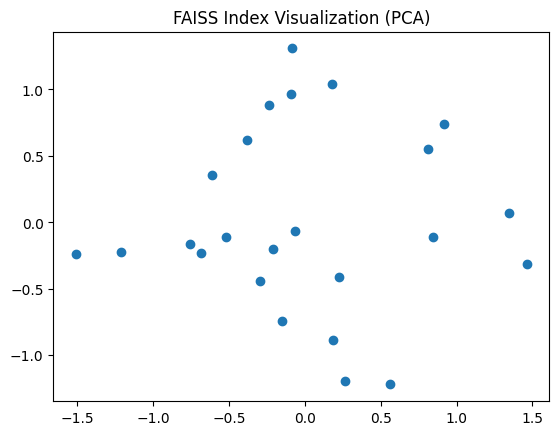

In [6]:
def visualize_faiss():
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    faiss_index = faiss.read_index(processed_faiss_path)
    if faiss_index.ntotal == 0:
        logger.warning("FAISS index is empty, nothing to visualize")
        return
    elif faiss_index.ntotal == 1:
        logger.warning("FAISS index has only 1 entry, visualizing as a single point")
        embeddings = faiss_index.reconstruct_n(0, 1)
        plt.scatter(embeddings[0, 0], embeddings[0, 1], s=100)
        plt.title("FAISS Index Visualization (Single Point)")
        plt.show()
        return

    embeddings = faiss_index.reconstruct_n(0, faiss_index.ntotal)
    pca = PCA(n_components=min(2, faiss_index.ntotal))
    reduced = pca.fit_transform(embeddings)

    plt.scatter(reduced[:, 0], reduced[:, 1] if reduced.shape[1] > 1 else np.zeros(reduced.shape[0]))
    plt.title("FAISS Index Visualization (PCA)")
    plt.show()

print("Visualizing FAISS index")
visualize_faiss()



In [7]:
def query_faiss(urs_name, section_name):
    faiss_index = faiss.read_index(processed_faiss_path)
    if faiss_index.ntotal == 0:
        logger.warning("FAISS index is empty, no query possible")
        return None
    query_embedding = np.random.rand(64).astype('float32')
    D, I = faiss_index.search(np.array([query_embedding]), 1)
    index = int(I[0][0])
    conn, cursor, id_seq = setup_database(db_params)
    cursor.execute("SELECT * FROM metadata WHERE id = %s", (index + 1,))
    result = cursor.fetchone()
    cursor.close()
    conn.close()
    return result

urs = input("Enter URS name to query: ")
section = input("Enter section name to query: ")
result = query_faiss(urs, section)
print(f"Query Result: {result}")

# Cleanup

print("Script completed")

Enter URS name to query: Analytical_Instrument_Data_Management_System
Enter section name to query: 
Connecting to database...
Creating metadata table if needed...
Database setup complete
Starting with database ID: 23
Query Result: (16, 'Analytical_Instrument_Data_Management_System', 'Description', 'text', 'Data Acquisition Module.', '[128, 648, 284, 666]', datetime.datetime(2025, 3, 5, 9, 23, 46, 751954))
Script completed
